# Train a Plane Detection Model from Voxel51 Dataset
This notebook trains a plane detection model using transfer learning. 
Depending on the label used, it can just detect a plane or it can try to detect the model of the plane.
A pre-trained model is used as a starting point. This means that fewer example images are needed and the training process is faster.

Images are exported from a Voxel51 Dataset into TensorFlow Records.The examples in the TFRecord are based on a selected Field from the Samples in the Voxel51 dataset. The V51 Sample field you choose should have 1 or more "detections", which are bounding boxes with a label.

From: https://colab.research.google.com/drive/1sLqFKVV94wm-lglFq_0kGo2ciM0kecWD#scrollTo=wHfsJ5nWLWh9&uniqifier=1

Good stuff here too: https://www.inovex.de/blog/deep-learning-mobile-tensorflow-lite/ 

## Configure the Training

In [2]:
training_name="jsm-322images-test-model" # The name for the model. All of the different directories will be based on this
label_field = "detections"  # The field from the V51 Samples around which will be used for the Labels for training.
dataset_name = "jsm-test-dataset" # The name of the V51 dataset that will be used


# Available Model Configs (You can add more from the TF2 Model Zoo)
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
        'batch_size': 24
    },
    'ssd_mobilenet_v2_fpnlite': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz',
        'batch_size': 18
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 18
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 18
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 18
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 18
    }
}

# change chosen model to deploy different models 
chosen_model = 'efficientdet-d0' #'ssd_mobilenet_v2'

num_steps = 5000 # The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 # Perform evaluation after so many steps



In [3]:
# The different directories and filenames to use
train_record_fname = "/tf/dataset-export/" + training_name + "/train/tf.records"
val_record_fname = "/tf/dataset-export/" + training_name + "/val/tf.records"
val_export_dir = "/tf/dataset-export/" + training_name + "/val/"
train_export_dir = "/tf/dataset-export/" + training_name + "/train/"
model_export_dir = "/tf/model-export/" + training_name +"/"

label_map_file = "/tf/dataset-export/" + training_name + "/label_map.pbtxt"

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

pipeline_fname = '/tf/models/research/deploy/' + base_pipeline_file
fine_tune_checkpoint = '/tf/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'
pipeline_file = '/tf/models/research/deploy/pipeline_file.config'
model_dir = '/tf/training/'+training_name+'/'

In [3]:
# Install the different packages needed
! apt install -y protobuf-compiler libgl1-mesa-glx wget

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
The following additional packages will be installed:
  libprotobuf10 libprotoc10
The following NEW packages will be installed:
  libprotobuf10 libprotoc10 protobuf-compiler wget
0 upgraded, 4 newly installed, 0 to remove and 11 not upgraded.
Need to get 1558 kB of archives.
After this operation, 5896 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 wget amd64 1.19.4-1ubuntu2.2 [316 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotobuf10 amd64 3.0.0-9.1ubuntu1 [651 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotoc10 amd64 3.0.0-9.1ubuntu1 [566 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 protobuf-compiler amd64 3.0.0-9.1ubuntu1 [24.5 kB]
Fetched 1558 kB in 1s (2012 kB/s)         
debconf: delaying package

## Download and Install TF Models
The TF Object Detection API is available here: https://github.com/tensorflow/models

In [4]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
   # pull v2.5.0 of tensorflow models to make deterministic 
   !git clone --depth 1 https://github.com/tensorflow/models/tree/v2.5.0 /tf/models

fatal: destination path '/tf/models' already exists and is not an empty directory.


In [5]:
%%bash
cd /tf/models/research
ls
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

README.md
adversarial_text
attention_ocr
audioset
autoaugment
cognitive_planning
cvt_text
deep_speech
deeplab
delf
deploy
efficient-hrl
lfads
lstm_object_detection
marco
nst_blogpost
object_detection
pcl_rl
rebar
seq_flow_lite
setup.py
slim
vid2depth
Processing /tf/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1650080 sha256=b0a1d3c1d61db5116585832e9aa45373abad40e7d21b2d9ad514fe2c42a7ba9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-7czjqprr/wheels/1b/00/50/d3675d90b11a88efdd99ed80b60a2b19e5769a0bb333440375
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44009 sha256=8fb3bf42acede91aa9508c2f240a47ef2b8af6d0399dd34930d3736531719642
  Stored in directory: /root/.cache/pip/wheels/5b/6f/ca/80164a844e4691238e34a8b139b4695354df4490db91be61f7
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp36-cp36m-linux_x86_64.whl size=265630 sha256=41122dcade4b42cafca1d13dc35c1ff483282a1484d7c

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

apache-beam 2.29.0 requires avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [6]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf
from object_detection.protos.string_int_label_map_pb2 import StringIntLabelMap, StringIntLabelMapItem
from google.protobuf import text_format
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## Export the Training and Val Dataset from Voxel 51

In [7]:
import fiftyone as fo
import math
dataset = fo.load_dataset(dataset_name)


### Explore the dataset content
Here are some basic stats on the Voxel51 dataset you are going to build training the model on. 
An example of the samples is also printed out. In the Sample, make sure the *label_field* you selected has some detections in it.

In [11]:
print("\t\tDataset\n-----------------------------------")
view = dataset.exists(label_field).shuffle(seed=51) # You can add additional things to the query to further refine it. eg .match_tags("good_box")
print(view)
print("\n\n\tExample Sample\n-----------------------------------")
print(view.first())


		Dataset
-----------------------------------
Dataset:     jsm-test-dataset
Media type:  image
Num samples: 322
Tags:        []
Sample fields:
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    external_id:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    bearing:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    elevation:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    distance:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    icao24:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    model:            fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    m

### Export the dataset into TFRecords
The selected dataset samples will be exported to TensorFlow Records (TFRecords). They will be split between Training and Validation. The ratio can be adjusted below. You only need to do this once to build the dataset. If you run this a second time with the same **model_name** additional samples will be appended to the end.

In [12]:
# The Dataset or DatasetView to export
sample_len = len(view)
val_len = math.floor(sample_len * 0.2)
train_len = math.floor(sample_len * 0.8)
print("Total: {} Val: {} Train: {}".format(sample_len,val_len,train_len))
val_view = view.take(val_len)
train_view = view.skip(val_len).take(train_len)
# Export the dataset
val_view.export(
    export_dir=val_export_dir,
    dataset_type=fo.types.TFObjectDetectionDataset,#fo.types.COCODetectionDataset,#fo.types.TFObjectDetectionDataset,
    label_field=label_field,
)

train_view.export(
    export_dir=train_export_dir,
    dataset_type=fo.types.TFObjectDetectionDataset,#fo.types.COCODetectionDataset,#fo.types.TFObjectDetectionDataset,
    label_field=label_field,
)

Total: 322 Val: 64 Train: 257
 100% |███████████████████| 64/64 [4.9s elapsed, 0s remaining, 55.6 samples/s]      
 100% |█████████████████| 257/257 [4.7s elapsed, 0s remaining, 55.4 samples/s]      


## Create a file with the Labels for the objects
The TF2 Object Detection API looks for a map of the labels used and a corresponding Id. You can build a list of the unique classnames by itterating the dataset. You can also just hardcode it if there only a few.

In [13]:
def convert_classes(classes, start=1):
    msg = StringIntLabelMap()
    for id, name in enumerate(classes, start=start):
        msg.item.append(StringIntLabelMapItem(id=id, name=name))

    text = str(text_format.MessageToBytes(msg, as_utf8=True), 'utf-8')
    return text

In [ ]:
# If labelfield is a classification
class_names=[]
for sample in view.select_fields(label_field):
    if sample[label_field].label not in class_names:
        class_names.append(sample[label_field].label)
print(class_names)

In [14]:
# If labelfield is detections
class_names=[]
for sample in view.select_fields(label_field):
    for detection in sample[label_field].detections:
        label = detection["label"]
        if label not in class_names:
            class_names.append(label)
print(class_names)

['plane']


In [ ]:
# You can hard wire it too
class_names=["plane"]

In [15]:

txt = convert_classes(class_names)
print(txt)
with open(label_map_file, 'w') as f:
        f.write(txt)

item {
  name: "plane"
  id: 1
}



## Download a pretrained Model & default Config
A list of the models can be found here: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

The configs are here: https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/

In [16]:
#download pretrained weights
%mkdir /tf/models/research/deploy/
%cd /tf/models/research/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

mkdir: cannot create directory ‘/tf/models/research/deploy/’: File exists
/tf/models/research/deploy
--2021-05-25 18:47:17--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.13.80, 2607:f8b0:4004:808::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.13.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz.1’

efficientdet_d0_coc 100%[===================>]  29.31M  18.1MB/s    in 1.6s    

2021-05-25 18:47:19 (18.1 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz.1’ saved [30736482/30736482]



In [17]:
#download base training configuration file
%cd /tf/models/research/deploy
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

/tf/models/research/deploy
--2021-05-25 18:47:26--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4630 (4.5K) [text/plain]
Saving to: ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config.2’

ssd_efficientdet_d0 100%[===================>]   4.52K  --.-KB/s    in 0s      

2021-05-25 18:47:26 (47.6 MB/s) - ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config.2’ saved [4630/4630]



## Build the Config for training
The default config for the model being trained needs to be updated with the correct parameters and paths to the data. This just adds some standard settings, you may need to do some additional tuning if the training is not working well.

In [18]:
# Gets the total number of classes from the Label Map

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_file)
print("working with {} classes".format(num_classes))

working with 1 classes


You may need to adjust the learning rate section below. The number used here are from the EfficentDet config. I noticed that this learning rate worked well for the small bounding boxes I was using when planes were at a high altitude. You can try increasing it if the planes take up more of the image. If the initial loss rates are high (>0) that is a probably a sign that you should adjust the Learning Rate.

You may also want to look at other aspects of the config file. They set the parameters for the model training and may need to be adjusted based on the Model Architecture you are using and the images you are training on.

In [19]:
# write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file

import re

%cd /tf/models/research/deploy
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_file), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set learning_rate_base in learning_rate, sane default
#     s = re.sub('learning_rate_base: [.0-9]+',
#                'learning_rate_base: {}'.format("8e-2"), s)
    
    # Set warmup_learning_rate in learning_rate, sane default
    s = re.sub('warmup_learning_rate: [.0-9]+',
               'warmup_learning_rate: {}'.format(.001), s)
    
    # Set warmup_steps in learning_rate, sane default
    s = re.sub('warmup_steps: [.0-9]+',
               'warmup_steps: {}'.format(2500), s)
    
    # Set total_steps in learning_rate, num_steps
    s = re.sub('total_steps: [0-9]+',
               'total_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    s = re.sub('random_scale_crop_and_pad_to_square {\s+output_size: 896\s+scale_min: 0.1\s+scale_max: 2.0\s+}',
               'random_crop_image {\n\tmin_object_covered: 1.0\n\tmin_aspect_ratio: 0.75\n\tmax_aspect_ratio: 1.5\n\tmin_area: 0.25\n\tmax_area: 0.875\n\toverlap_thresh: 0.5\n\trandom_coef: 0.125\n}',s, flags=re.MULTILINE)
    
    s = re.sub('ssd_random_crop {\s+}',
               'random_crop_image {\n\tmin_object_covered: 1.0\n\tmin_aspect_ratio: 0.75\n\tmax_aspect_ratio: 1.5\n\tmin_area: 0.10\n\tmax_area: 0.75\n\toverlap_thresh: 0.5\n\trandom_coef: 0.125\n}',s, flags=re.MULTILINE)
    
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)

/tf/models/research/deploy
writing custom configuration file


In [ ]:
%cat /tf/models/research/deploy/pipeline_file.config

# Train Custom TF2 Object Detector

This step will launch the TF2 Object Detection training. It can take a while to start-up. 
If you get an error about not finding the GPU, try shutting down the Jupyter kernel and restarting it.
While it is running, it should print out the Current Loss and which Step it is on.

* pipeline_file: defined above in writing custom training configuration
* model_dir: the location tensorboard logs and saved model checkpoints will save to
* num_train_steps: how long to train for
* num_eval_steps: perform eval on validation set after this many steps

In [ ]:
# 2:48 PM ET Tuesday, May 25, 2021
!python /tf/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps} 

2021-05-25 18:48:32.667547: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-05-25 18:48:35.529336: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-25 18:48:35.553681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-25 18:48:35.554497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-05-25 18:48:35.554547: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-05-25 18:48:35.558309: I tensorflow/stream_executor/platform/defa

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0525 18:48:36.507974 140484065732416 cross_device_ops.py:621] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0525 18:48:36.514587 140484065732416 efficientnet_model.py:147] round_filter input=32 output=32
I0525 18:48:36.514709 140484065732416 efficientnet_model.py:147] round_filter input=16 output=16
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0525 18:48:36.534847 140484065732416 cross_device_ops.py:621] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0525 18:48:

Instructions for updating:
Use `tf.cast` instead.
W0525 18:48:51.369795 140484065732416 deprecation.py:336] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:464: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
2021-05-25 18:48:54.042741: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-05-25 18:48:54.070444: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2

W0525 18:49:46.704102 140484065732416 util.py:162] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.8
W0525 18:49:46.704169 140484065732416 util.py:162] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.1
W0525 18:49:46.704243 140484065732416 util.py:162] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.2
W0525 18:49:46.704323 140484065732416 util.py:162] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.4
W0525 18:49:46.704410 140484065732416 util.py:162] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.5
W0525 18:49:46.704547 140484065732416 util.py:162] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_l

W0525 18:49:59.492486 140478087415552 utils.py:80] Gradients do not exist for variables ['top_bn/gamma:0', 'top_bn/beta:0'] when minimizing the loss.
Instructions for updating:
Use fn_output_signature instead
W0525 18:50:00.924770 140478087415552 deprecation.py:534] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:602: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
W0525 18:50:15.308885 140478087415552 utils.py:80] Gradients do not exist for variables ['top_bn/gamma:0', 'top_bn/beta:0'] when minimizing the loss.
W0525 18:50:29.987735 140478087415552 utils.py:80] Gradients do not exist for variables ['top_bn/gamma:0', 'top_bn/beta:0'] when minimizing the loss.
W0525 18:50:45.417664 140478087415552 utils.py:80] Gradients do not exist for variables ['top_bn/gamma:0', 'top_bn/beta:0'] when minimizing the loss.
INFO:tensorflow:S

# Evaluate trained model
After the model has finished training, try running it against some data to see if it atleast works.

In [1]:

import matplotlib
import matplotlib.pyplot as plt

import io, os, glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [4]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [5]:
%ls {model_dir}

checkpoint                  ckpt-4.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-4.index
ckpt-1.index                ckpt-5.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-5.index
ckpt-2.index                ckpt-6.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-6.index
ckpt-3.index                train/


## Load model from a training checkpoint
Select a checkpoint index from above

In [6]:
# generally you want to put the last ckpt index from training in here
checkpoint_index=6

# recover our saved model
pipeline_config = pipeline_file

checkpoint = model_dir + "ckpt-" + str(checkpoint_index)
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(checkpoint)).expect_partial()


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [7]:
# map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

tf.Tensor(
[[0.5497315  0.02935953 0.01565678 0.01440458 0.01192949 0.01080719
  0.01052422 0.01025228 0.00955969 0.00909134 0.00854407 0.00818302
  0.00750065 0.0074914  0.00745117 0.00738956 0.00708383 0.0069595
  0.00695896 0.00692936 0.00670204 0.00649661 0.00646188 0.00631359
  0.00630669 0.00622969 0.00613054 0.00612627 0.00611053 0.00603262
  0.00603173 0.00598834 0.00596929 0.00593658 0.00593172 0.00590648
  0.00585248 0.00583878 0.00574185 0.00568485 0.00568144 0.00567391
  0.00563786 0.00562629 0.00561598 0.00556482 0.0055298  0.00546814
  0.005465   0.00542139 0.00541946 0.00530157 0.00520765 0.00519105
  0.00514679 0.00510268 0.00509748 0.00509733 0.00507789 0.00506378
  0.00495194 0.00494764 0.00494358 0.00485717 0.00485501 0.00481327
  0.00477765 0.00471261 0.00470589 0.00468634 0.00459482 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  

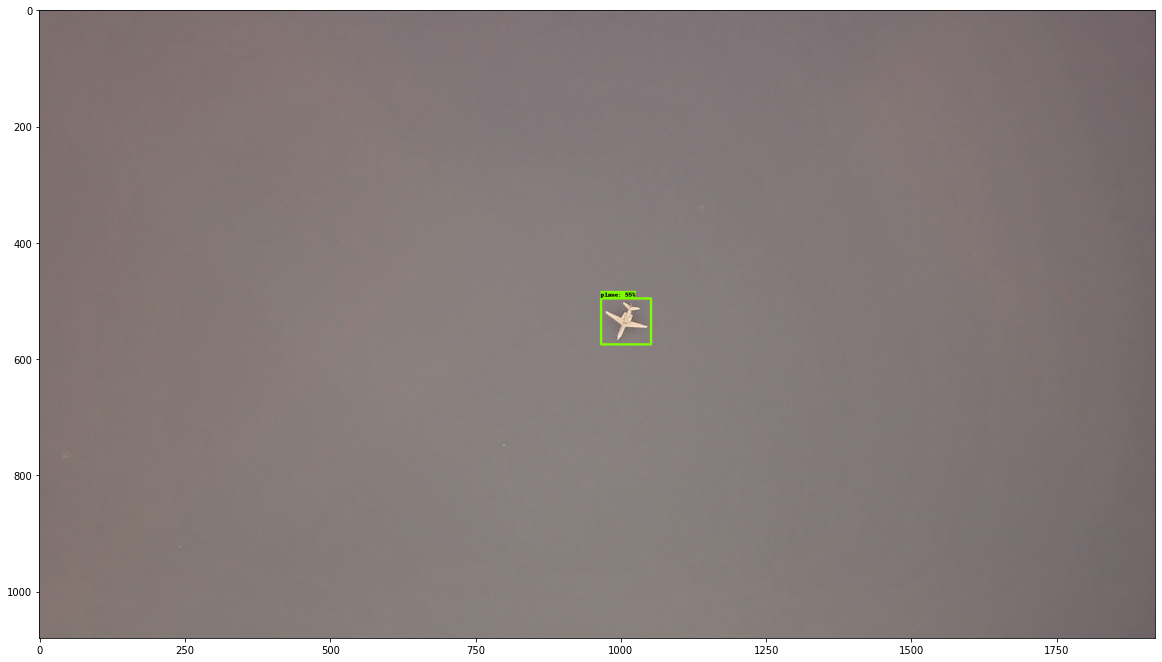

In [17]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

TEST_IMAGE_PATHS = glob.glob('/tf/media/capture-5-13/Textron Aviation Inc 680A/*.jpg') #/tf/dataset-export/pet/images/keeshond_171.jpg') #'/tf/testing/Dassault Aviation FALCON 2000/*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

detections, predictions_dict, shapes = detect_fn(input_tensor)


print(detections['detection_scores'])
label_id_offset = 1 # Depending on whether your LabelMap starts at 0 or 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.2,
      agnostic_mode=False,
)

plt.figure(figsize=(20,25))
plt.imshow(image_np_with_detections)
plt.show()

# Export the model
When you have a working model, use the TF2 Object Detection API to export it to a saved model.

### Export a Saved Model that uses Image Tensors

In [23]:
image_tensor_model_export_dir = model_export_dir + "image_tensor_saved_model"

In [24]:
!python /tf/models/research/object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --trained_checkpoint_dir={model_dir} \
    --pipeline_config_path={pipeline_file} \
    --output_directory {image_tensor_model_export_dir}

2021-06-21 14:54:15.996813: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-21 14:54:18.704963: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-21 14:54:18.732034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-21 14:54:18.732557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-06-21 14:54:18.732621: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-21 14:54:18.737241: I tensorflow/stream_executor/platform/defa

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0621 14:54:23.574198 140543996131136 deprecation.py:601] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:463: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0621 14:54:45.151293 140543996131136 save_impl.py:77] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7fd270859278>, because it is not built.
2021-06-21 14:55:14.814361: W tensorfl

### Export a Saved Model that uses TF Examples

In [20]:
tf_example_model_export_dir = model_export_dir + "tf_example_saved_model"

In [21]:
!python /tf/models/research/object_detection/exporter_main_v2.py \
    --input_type=tf_example \
    --trained_checkpoint_dir={model_dir} \
    --pipeline_config_path={pipeline_file} \
    --output_directory {tf_example_model_export_dir}

2021-06-21 14:49:54.037010: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-21 14:49:56.777151: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-21 14:49:56.804016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-21 14:49:56.804408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-06-21 14:49:56.804452: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-21 14:49:56.808529: I tensorflow/stream_executor/platform/defa

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0621 14:50:01.595117 140032503969600 deprecation.py:601] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:463: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Instructions for updating:
Use fn_output_signature instead
W0621 14:50:15.315417 140032503969600 deprecation.py:534] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:464: calling map_fn (from tensorflow.python.ops.ma

### Export a TFLite compatible model
Remeber that only Detection models that use SSDs are supported

In [ ]:
!python /tf/models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path={pipeline_file} \
  --trained_checkpoint_dir={model_dir} \
  --output_directory={model_export_dir}tflite-compatible


In [22]:
# I think we skip this step...

#! tflite_convert \
#    --saved_model_dir="{model_export_dir}tflite-compatible/saved_model" \
#    --output_file="{model_export_dir}output.tflite"

In [ ]:
#https://github.com/tensorflow/models/issues/9033#issuecomment-706573546
import cv2
import glob
import numpy as np

train_images = []

def representative_data_gen():
    path = '/tf/testing/Airbus A319-115'

    dataset_list = tf.data.Dataset.list_files(path + '/*.jpg')
    for i in range(100):
        image = next(iter(dataset_list))
        image = tf.io.read_file(image)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [300, 300])
        image = tf.cast(image / 255., tf.float32)
        image = tf.expand_dims(image, 0)
        yield [image]


converter = tf.lite.TFLiteConverter.from_saved_model(model_export_dir+"tflite-compatible/saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
                                       tf.lite.OpsSet.TFLITE_BUILTINS]
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

# Save the model.
with open(model_export_dir+'model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | tee /etc/apt/sources.list.d/coral-edgetpu.list
!apt-get update
!apt-get -y install edgetpu-compiler

In [ ]:
!edgetpu_compiler -s {model_export_dir}model.tflite -o {model_export_dir}

### Export a TensorJS compatible model
From: https://www.tensorflow.org/js/tutorials/conversion/import_saved_model

In [ ]:
!pip install tensorflowjs

In [ ]:
! tensorflowjs_converter \
    --input_format=tf_saved_model \
    {model_export_dir}image_tensor_saved_model/saved_model \
    {model_export_dir}web_model

In [ ]:
!saved_model_cli show --dir /tf/models/research/deploy/ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model --all